# $B_E$ speed dependancy

In [1]:
from src.notebook_to_latex import Equation, equation_dict
from rolldecayestimators import equations_ikeda_naked

Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


# Purpose
Investigating the speed dependancy of the eddy damping $B_E$ by looking the the MDL database. Ikeda express the speed dependancy as:

In [2]:
Equation(equations_ikeda_naked.eq_eddy_speed, label='eq:eddy_speed')

<src.notebook_to_latex.Equation object>

But where does the 0.0016 term come from? Is there a better value, when looking at results from MDL db? It seems that it is a fit to the following results:
![](B_E_speed.PNG)

# Methodology
Create something similar to the plot above, but based on MDL DB. It can be assumed that for a ship ship without bilge keels the eddy damping $B_E$ represent the nonlinear part of the damping.
Using $B_1$, $B_2$ and $B_3$, $B_E$ should therefore represent what is in the $B_2$ coefficient. 

# Setup

In [12]:
# %load imports.py
"""
These is the standard setup for the notebooks.
"""

%matplotlib inline
%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
#plt.style.use('paper')
from reports.paper_writing import save_fig

#import data
import copy
from mdldb.run import Run

from sklearn.pipeline import Pipeline
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
from rolldecayestimators.direct_estimator_cubic import EstimatorQuadraticB, EstimatorCubic
from rolldecayestimators.ikeda_estimator import IkedaQuadraticEstimator
import src.equations as equations
import rolldecayestimators.lambdas as lambdas
from rolldecayestimators.substitute_dynamic_symbols import lambdify
import rolldecayestimators.symbols as symbols
import sympy as sp

from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex

from sklearn.metrics import r2_score
from src.data import database
from mdldb import tables
import shipflowmotionshelpers.shipflowmotionshelpers as helpers
import src.visualization.visualize as visualize


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
df_rolldecay = database.load(limit_score=0.995)
df_rolldecay['BKL'].fillna(0,inplace=True)
scale_factor = df_rolldecay.scale_factor
df_rolldecay['V'] = df_rolldecay.ship_speed*1.852/3.6/np.sqrt(scale_factor)

In [67]:
mask = df_rolldecay['BKL'] == 0
df_bare_hull = df_rolldecay.loc[mask].copy()

In [92]:
for loading_condition_id, df in df_bare_hull.groupby(by='loading_condition_id'):
    
    if len(df['ship_speed'].unique()) == 1:
        continue
        
    mask = df['ship_speed'] == 0
    df_zero_speed = df.loc[mask]
    
    if len(df_zero_speed) == 0:
        continue
        
    zero_speed = df_zero_speed.iloc[0].copy()
    
    factor = df['B_2A'] / zero_speed['B_2A']  ## Assuming that B_E is proportional to B_2        
    
    df_bare_hull.loc[df.index,r'B_E/B_E0'] = factor
           
        
    
    

In [93]:
Equation(equations_ikeda_naked.eq_K, label='eq:K')

<src.notebook_to_latex.Equation object>

In [94]:
lambda_K = lambdify(equations_ikeda_naked.eq_K.rhs)

In [95]:
lpp = df_bare_hull.lpp/scale_factor
df_bare_hull['K'] = lambda_K(L_pp=lpp, V=df_bare_hull.V, omega=df_bare_hull.omega0)
df_bare_hull[r'1/K'] = 1/df_bare_hull['K']

<AxesSubplot:xlabel='1/K'>

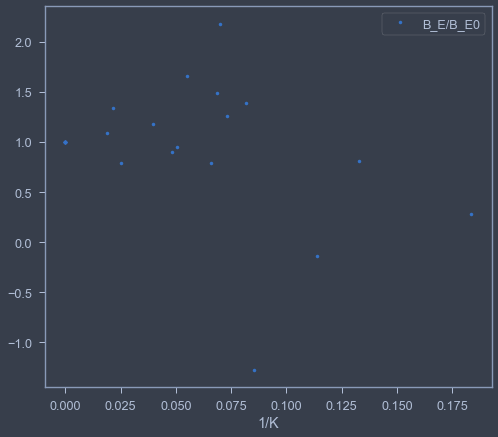

In [96]:
fig,ax=plt.subplots()
df_bare_hull.plot(x='1/K', y = r'B_E/B_E0', ax=ax, style = '.')

In [74]:
equations.B_e_equation

Eq(B_e, B_1 + 8*B_2*omega0*phi_a/(3*pi))

In [75]:
equations.B_2_hat_equation

Eq(B_2_hat, B_2/(Disp*beam**2*rho))